In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import required libraries

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os

print("TensorFlow version:", tf.__version__)
tf.keras.utils.set_random_seed(42)

TensorFlow version: 2.19.0


In [45]:
IMG_SIZE = 32 # CIFAR-10 images are 32x32
PATCH_SIZE = 4 # 4x4 -> (32/4)^2 = 64 tokens
EMBED_DIM = 192 # token/hidden dimension
NUM_HEADS = 3  # heads (EMBED_DIM % NUM_HEADS == 0)
MLP_RATIO = 4  # FFN hidden = EMBED_DIM * MLP_RATIO
DEPTH = 6 # transformer blocks
DROP_RATE = 0.1
WEIGHT_DECAY  = 5e-5
LR = 3e-4
BATCH_SIZE = 128
EPOCHS = 20
NUM_CLASSES   = 10

In [46]:
file_path = os.path.abspath(os.path.join(os.getcwd(), "drive", "MyDrive", "hair_data"))
print(os.listdir(file_path))

['Wavy Hair', 'Straight Hair', 'Curly Hair']


load CIFAR-10 and prepare datasets

In [65]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    file_path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=42
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    file_path,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=42
)

class_names = raw_train_ds.class_names
print("Classes:", class_names)

# then normalize + prefetch
norm_layer = layers.Rescaling(1./255)
train_ds = raw_train_ds.map(lambda x,y: (norm_layer(x), y)).prefetch(tf.data.AUTOTUNE)
val_ds   = raw_val_ds.map(lambda x,y: (norm_layer(x), y)).prefetch(tf.data.AUTOTUNE)


Found 994 files belonging to 3 classes.
Using 796 files for training.
Found 994 files belonging to 3 classes.
Using 198 files for validation.
Classes: ['Curly Hair', 'Straight Hair', 'Wavy Hair']


In [66]:
#Patch + Position embedding (fixed)
class PatchEncoder(layers.Layer):
    """Image -> sequence of patch embeddings + positional encodings"""
    def __init__(self, img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.proj = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size,
                                  padding="valid")
        self.flatten = layers.Reshape((num_patches, embed_dim))
        self.pos_emb = self.add_weight(
            name="pos_emb",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal"
        )

    def call(self, x):
        x = self.proj(x)            # (B, H/patch, W/patch, embed_dim)
        x = self.flatten(x)         # (B, num_patches, embed_dim)
        return x + self.pos_emb     # add positional embeddings


In [67]:
# Transformer Encoder block
def transformer_block(x, embed_dim, num_heads, mlp_ratio=4, drop_rate=0.1):
    # LayerNorm + MSA
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x1, x1)
    x2 = layers.Add()([x, attn])  # residual

    # LayerNorm + MLP
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    mlp_hidden = embed_dim * mlp_ratio
    mlp = keras.Sequential([
        layers.Dense(mlp_hidden, activation=tf.nn.gelu),
        layers.Dropout(drop_rate),
        layers.Dense(embed_dim),
        layers.Dropout(drop_rate),
    ])
    x3 = mlp(x3)
    return layers.Add()([x2, x3])  # residual


In [68]:
#Build the ViT model
def build_vit():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = PatchEncoder()(inputs)

    for _ in range(DEPTH):
        x = transformer_block(x, EMBED_DIM, NUM_HEADS, MLP_RATIO, DROP_RATE)

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)  # mean pool over tokens
    x = layers.Dropout(DROP_RATE)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="ViT")

model = build_vit()
model.summary()


Model: "ViT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_4     │ (None, 64, 192)   │     21,696 │ input_layer_24[0… │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ patch_encoder_4[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    444,288 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 64, 192)   │          0 │ patch_encoder_4[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_36[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 64, 192)   │    295,872 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 64, 192)   │          0 │ add_36[0][0],     │
│                     │                   │            │ sequential_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_37[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    444,288 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_38 (Add)        │ (None, 64, 192)   │          0 │ add_37[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_38[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 64, 192)   │    295,872 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 64, 192)   │          0 │ add_38[0][0],     │
│                     │                   │            │ sequential_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 192)   │        384 │ add_39[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 192)   │    444,288 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 64, 192)   │          0 │ add_39[0][0],   

 Total params: 4,468,227 (17.04 MB)

 Trainable params: 4,468,227 (17.04 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
from PIL import Image
import os

def reencode_images(base_path, out_format="JPEG"):
    bad = []
    for root, _, files in os.walk(base_path):
        for f in files:
            path = os.path.join(root, f)
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                try:
                    img = Image.open(path).convert("RGB")
                    # force re-save as proper jpg
                    img.save(path, format=out_format)
                except Exception as e:
                    bad.append(path)
    return bad

bad_files = reencode_images(file_path, out_format="JPEG")
print("Re-encoded. Bad files skipped:", bad_files)


Re-encoded. Bad files skipped: []


In [59]:
# Compile & Train (using built-in AdamW)
optimizer = keras.optimizers.AdamW(
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY
)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.3403 - loss: 3.6925 - val_accuracy: 0.3434 - val_loss: 1.3725
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step - accuracy: 0.3221 - loss: 1.5616 - val_accuracy: 0.3232 - val_loss: 1.1042
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 545ms/step - accuracy: 0.2969 - loss: 1.2458 - val_accuracy: 0.3434 - val_loss: 1.1637
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 431ms/step - accuracy: 0.3357 - loss: 1.2221 - val_accuracy: 0.3333 - val_loss: 1.1795
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 597ms/step - accuracy: 0.3575 - loss: 1.2145 - val_accuracy: 0.3434 - val_loss: 1.1167
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step - accuracy: 0.3424 - loss: 1.2011 - val_accuracy: 0.3333 - val_loss: 1.1071
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.3462 - loss: 1.1637 - val_accuracy: 0.3182 - val_loss: 1.1005
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.3504 - loss: 1.1767 - val_accuracy: 0.3434 - val_loss: 1

plot training curves

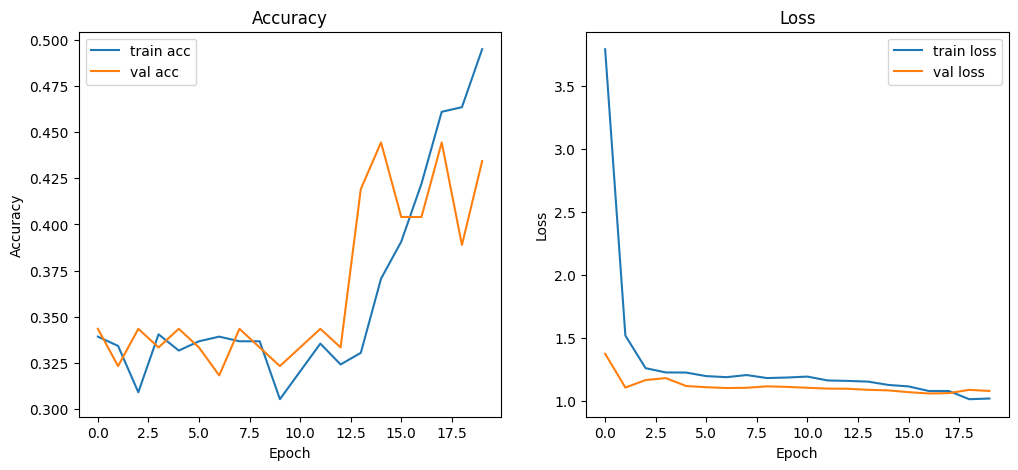

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


Inspect predictions
to check if the model actually classifies your images correctly:

In [82]:
# from tensorflow.keras.utils import load_img, img_to_array
# import os

# # pick a random file from your dataset folder
# img_path = os.path.join(file_path, "Curly Hair", "0b7aa42d28a71654681bfd13b569ce32.jpg")

# # load at high resolution (e.g. 224x224 or original size)
# high_res_img = load_img(img_path, target_size=None)  # None = keep original size

# plt.imshow(high_res_img)
# plt.axis("off")
# plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted: Wavy Hair (confidence: 0.87)


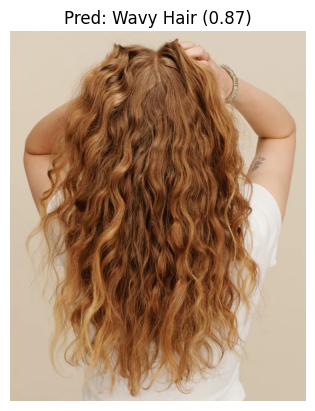

In [84]:
test_image = 'aa.jpg'
# img = load_img(test_image)
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os


img = load_img(test_image, target_size=(IMG_SIZE, IMG_SIZE))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# predict
preds = model.predict(img_array)
pred_label = np.argmax(preds, axis=-1)[0]
confidence = np.max(preds)

print(f"Predicted: {class_names[pred_label]} (confidence: {confidence:.2f})")
orig_img = load_img(test_image)
plt.imshow(orig_img)
plt.title(f"Pred: {class_names[pred_label]} ({confidence:.2f})")
plt.axis("off")
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


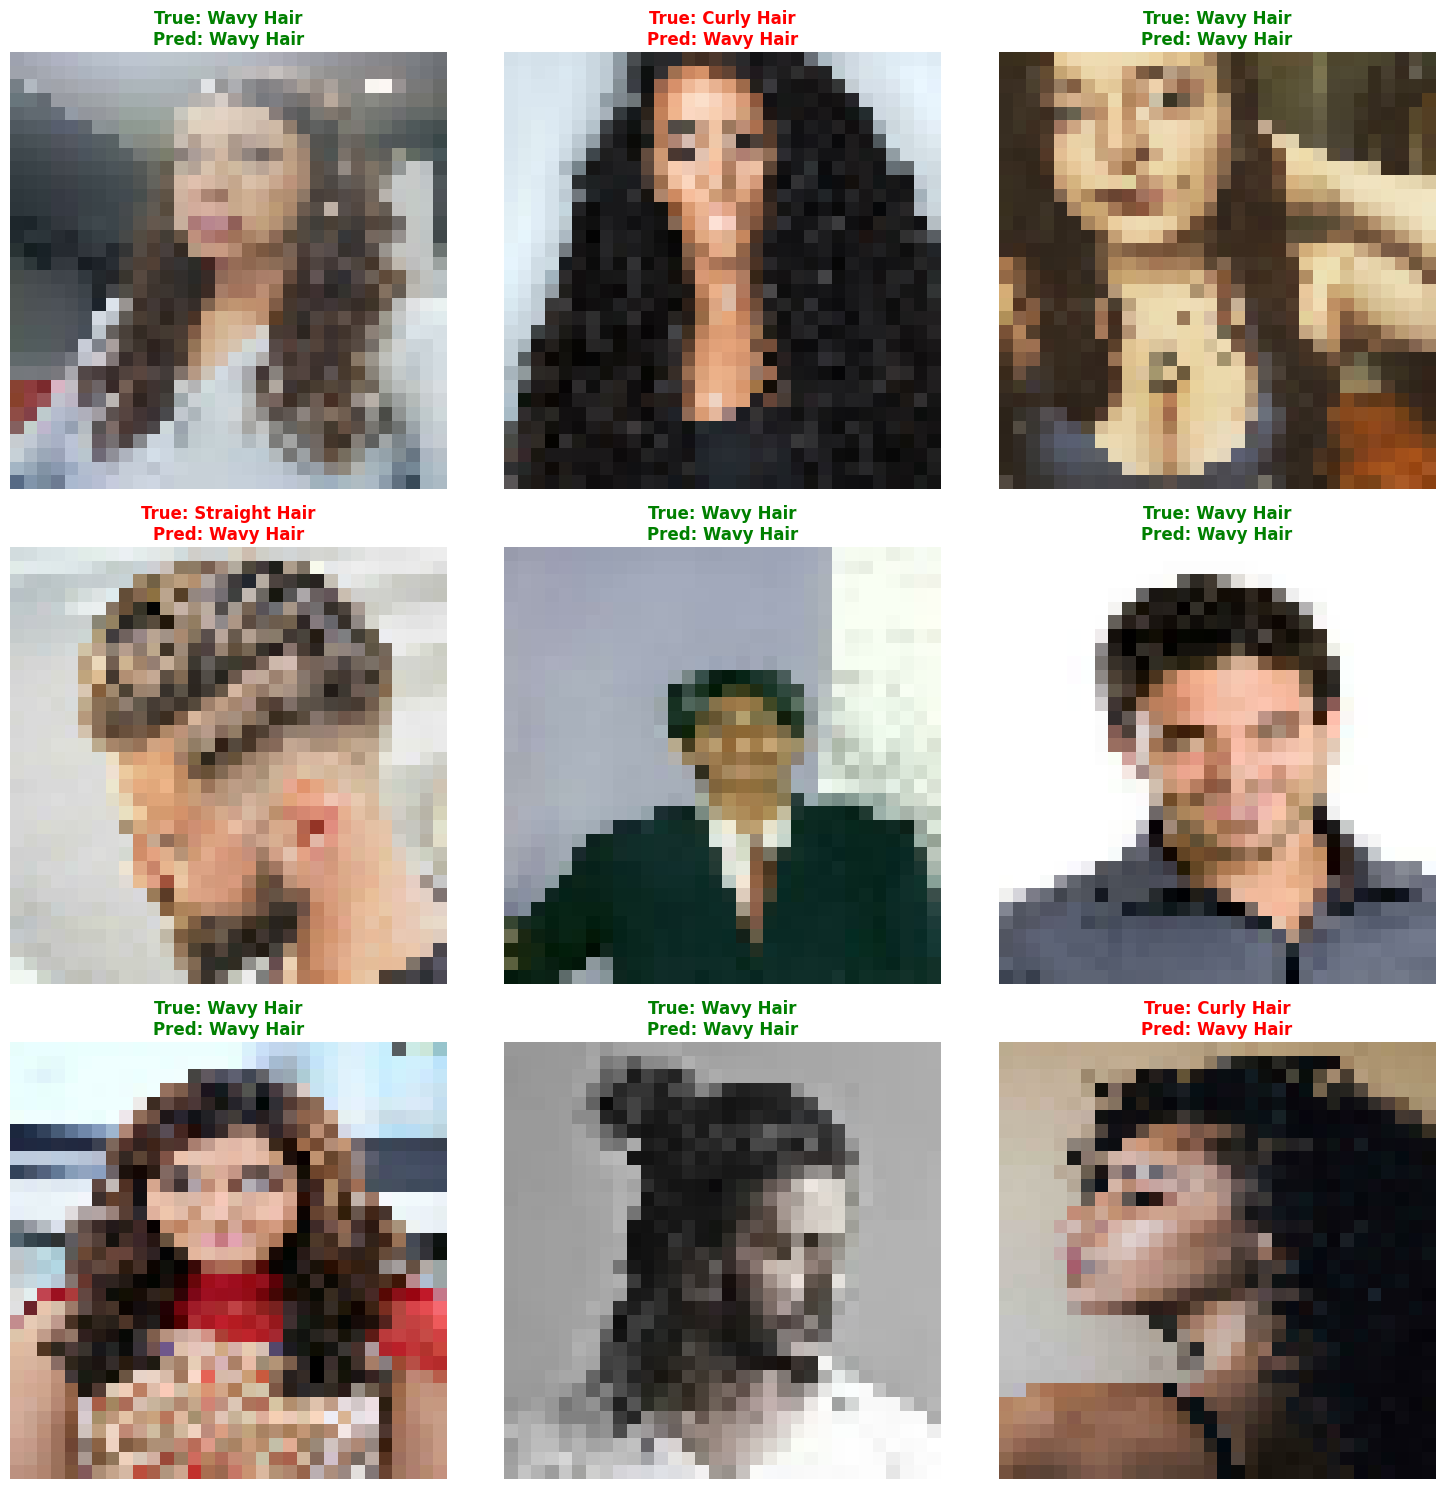

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# take one batch
x_batch, y_batch = next(iter(val_ds))
preds = model.predict(x_batch)
pred_labels = np.argmax(preds, axis=-1)

# plot
plt.figure(figsize=(15, 15))   # larger canvas
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i].numpy().astype("float32"))

    true_label = class_names[y_batch[i]]
    pred_label = class_names[pred_labels[i]]

    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"True: {true_label}\nPred: {pred_label}",
                 color=color, fontsize=12, fontweight="bold")

    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
model.save("vit_hair_classifier.h5")